In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from data import load_dataset, get_train_test_split

In [4]:
filename = "dataset/LoanStats3a.csv"
features, data = load_dataset(filename, encoding='utf-8')
print("Data shape: %s" % str(features.shape))

Preprocessing...
Feature Engineering...
Data shape: (42535, 40)


In [150]:
"""
EXPERIMENT 2: GP VS BAYES OPT IN EARLY STAGES
-------------------------------------------------------
Set up:
1. Let K = 100-500.
2. Create two GP models: gp_model_normal and gp_model_bayes_opt.
3. [OPTIONAL] Create an SVM model.
Experiment:
1. Train gp_model_normal using K randomly chosen data rows. Then let it do pure prediction.
2. Train gp_model_bayes_opt iteratively K steps. Each step explore the row with large acquisition function. Then pure prediction.
3. [OPTIONAL] Train svm_model with the same set in step 1 and let it predict to compare.
4. [OPTIONAL] Train svm_model with the same set in step 2 and let it predict to compare.
Results:
1. Compare the 3 profits gained at the end of all periods.
"""

from sklearn.model_selection import train_test_split
from scipy.stats import norm

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

SEED            = 1
THRESHOLD       = 1.1
NUM_PERIODS     = 20
NUM_MONTHS      = 60
FUND_GIVEN      = 0
FUND_FLOW       = 1e4
LOANS_PER_MONTH = 100
CONF_QUANTILE   = (40,100)
NUM_TRAIN_ROWS_GP = 200
NUM_TRAIN_ROWS_BO = 50
GP_TRAIN_SEED   = 2
BO_TRAIN_SEED   = 2
KAPPA = 5# norm.ppf(0.75)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
# Data initialization
X_train, X_test, y_train, y_test = get_train_test_split(features, test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.2, random_state=0)

# Normal GP training data init
X_train_normal, _, y_train_normal, _ = train_test_split(X_train, y_train,
                                                        train_size=NUM_TRAIN_ROWS_GP,
                                                        random_state=GP_TRAIN_SEED)

# BO GP training data init
X_train_bo, _, y_train_bo, _ = train_test_split(X_train, y_train, train_size=1, random_state=BO_TRAIN_SEED)

# Normalize
X_scaler = MinMaxScaler()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)
X_train_normal = X_scaler.transform(X_train_normal)
X_train_bo = X_scaler.transform(X_train_bo)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train.reshape(-1,1))
y_train_scaled = y_scaler.transform(y_train.reshape(-1,1))
y_val_scaled = y_scaler.transform(y_val.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))
y_train_normal_scaled = y_scaler.transform(y_train_normal.reshape(-1,1))
y_train_bo_scaled = y_scaler.transform(y_train_bo.reshape(-1,1))

print("X_train: %s, y_train_scaled: %s" % (str(X_train.shape), str(y_train_scaled.shape)))
print("X_val: %s, y_val_scaled: %s" % (str(X_val.shape), str(y_val_scaled.shape)))
print("X_test: %s, y_test_scaled: %s" % (str(X_test.shape), str(y_test_scaled.shape)))
print("X_train_normal: {}, y_train_normal_scaled: {}".format(X_train_normal.shape, y_train_normal_scaled.shape))
print("X_train_bo: {}, y_train_bo_scaled: {}".format(X_train_bo.shape, y_train_bo_scaled.shape))

X_train: (5954, 38), y_train_scaled: (5954, 1)
X_val: (23820, 38), y_val_scaled: (23820, 1)
X_test: (12761, 38), y_test_scaled: (12761, 1)
X_train_normal: (200, 38), y_train_normal_scaled: (200, 1)
X_train_bo: (1, 38), y_train_bo_scaled: (1, 1)


In [152]:
# Normal GP model init
import GPy
kernel = GPy.kern.RBF(input_dim=X_train.shape[1], variance=1., lengthscale=1.)
gp_model_normal = GPy.models.GPRegression(X_train_normal, y_train_normal_scaled, kernel)
gp_model_normal.optimize()

In [153]:
# Bayesian Optimization GP model init
import GPy
import numpy as np

from features import get_loan_amnt
kernel = GPy.kern.RBF(input_dim=X_train_bo.shape[1], variance=1., lengthscale=1.)

print(X_train_bo.shape)
print(y_train_bo_scaled.shape)

gp_model_bay_opt = GPy.models.GPRegression(X_train_bo, y_train_bo_scaled, kernel)
gp_model_bay_opt.optimize()

for i in range(NUM_TRAIN_ROWS_BO):
    mean, var = gp_model_bay_opt.predict(X_train)
    acquisition = mean + np.sqrt(var)*KAPPA # - get_loan_amnt(X_train).reshape(-1, 1)
    next_sample_ind = acquisition.argmax()
    next_sample_X = X_train[next_sample_ind].reshape(1, -1)
    next_sample_y = y_train_scaled[next_sample_ind].reshape(1, -1)
    X_train_bo = np.concatenate((X_train_bo, next_sample_X), axis=0)
    y_train_bo_scaled = np.concatenate((y_train_bo_scaled, next_sample_y), axis=0)
    X_train = np.delete(X_train, next_sample_ind, axis=0)
    y_train_scaled = np.delete(y_train_scaled, next_sample_ind, axis=0)
    gp_model_bay_opt.set_XY(X=X_train_bo, Y=y_train_bo_scaled)
    gp_model_bay_opt.optimize()

(1, 38)
(1, 1)


In [154]:
# Properly init test dataset
# TODO TODO TODO TODO
print("gp_normal: {} {}".format(gp_model_normal.X.shape, gp_model_normal.Y.shape))
print("gp_bay_opt: {} {}".format(gp_model_bay_opt.X.shape, gp_model_bay_opt.Y.shape))

gp_normal: (200, 38) (200, 1)
gp_bay_opt: (51, 38) (51, 1)


In [155]:
from simulation import *

perf_gp = simulate_N_time_periods(
    gp_model_normal,
    X_val, y_val,
    X_scaler, y_scaler,
    threshold=THRESHOLD,
    num_periods=NUM_PERIODS,
    fund_given=FUND_GIVEN,
    num_months=NUM_MONTHS,
    flow=FUND_FLOW,
    incoming_loans_per_time_period=LOANS_PER_MONTH,
    conf_quantile=CONF_QUANTILE,
    optimize_for="TODO", 
    version="loan_amount_and_variance",
    model_type="gp",
    seed=SEED
)
print("Profits for self-updating GP:")
print(np.mean(np.sum(perf_gp[:,:,0], axis=1)))

Simulating period 0...
month: 0
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
month: 13
month: 14
month: 15
month: 16
month: 17
month: 18
month: 19
month: 20
month: 21
month: 22
month: 23
month: 24
month: 25
month: 26
month: 27
month: 28
month: 29
month: 30
month: 31
month: 32
month: 33
month: 34
month: 35
month: 36
month: 37
month: 38
month: 39
month: 40
month: 41
month: 42
month: 43
month: 44
month: 45
month: 46
month: 47
month: 48
month: 49
month: 50
month: 51
month: 52
month: 53
month: 54
month: 55
month: 56
month: 57
month: 58
month: 59
Simulating period 1...
month: 0
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
month: 13
month: 14
month: 15
month: 16
month: 17
month: 18
month: 19
month: 20
month: 21
month: 22
month: 23
month: 24
month: 25
month: 26
month: 27
month: 28
month: 29
month: 30
month: 31
month: 32
month: 33
month: 34
month: 35
month: 36
mont

month: 52
month: 53
month: 54
month: 55
month: 56
month: 57
month: 58
month: 59
Simulating period 14...
month: 0
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
month: 13
month: 14
month: 15
month: 16
month: 17
month: 18
month: 19
month: 20
month: 21
month: 22
month: 23
month: 24
month: 25
month: 26
month: 27
month: 28
month: 29
month: 30
month: 31
month: 32
month: 33
month: 34
month: 35
month: 36
month: 37
month: 38
month: 39
month: 40
month: 41
month: 42
month: 43
month: 44
month: 45
month: 46
month: 47
month: 48
month: 49
month: 50
month: 51
month: 52
month: 53
month: 54
month: 55
month: 56
month: 57
month: 58
month: 59
Simulating period 15...
month: 0
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
month: 13
month: 14
month: 15
month: 16
month: 17
month: 18
month: 19
month: 20
month: 21
month: 22
month: 23
month: 24
month: 25
month: 26
month: 27
month: 28
mo

In [156]:
from simulation import *

perf_bayes_opt = simulate_N_time_periods(
    gp_model_bay_opt,
    X_val, y_val,
    X_scaler, y_scaler,
    threshold=THRESHOLD,
    num_periods=NUM_PERIODS,
    fund_given=FUND_GIVEN, 
    num_months=NUM_MONTHS,
    flow=FUND_FLOW,
    incoming_loans_per_time_period=LOANS_PER_MONTH,
    conf_quantile=CONF_QUANTILE,
    optimize_for="TODO",
    version="loan_amount_and_variance",
    model_type="gp", seed=SEED
)
print("Profits for Bayesian Optimization:")
print(np.mean(np.sum(perf_bayes_opt[:,:,0], axis=1)))

Simulating period 0...
month: 0
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
month: 13
month: 14
month: 15
month: 16
month: 17
month: 18
month: 19
month: 20
month: 21
month: 22
month: 23
month: 24
month: 25
month: 26
month: 27
month: 28
month: 29
month: 30
month: 31
month: 32
month: 33
month: 34
month: 35
month: 36
month: 37
month: 38
month: 39
month: 40
month: 41
month: 42
month: 43
month: 44
month: 45
month: 46
month: 47
month: 48
month: 49
month: 50
month: 51
month: 52
month: 53
month: 54
month: 55
month: 56
month: 57
month: 58
month: 59
Simulating period 1...
month: 0
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
month: 13
month: 14
month: 15
month: 16
month: 17
month: 18
month: 19
month: 20
month: 21
month: 22
month: 23
month: 24
month: 25
month: 26
month: 27
month: 28
month: 29
month: 30
month: 31
month: 32
month: 33
month: 34
month: 35
month: 36
mont

month: 16
month: 17
month: 18
month: 19
month: 20
month: 21
month: 22
month: 23
month: 24
month: 25
month: 26
month: 27
month: 28
month: 29
month: 30
month: 31
month: 32
month: 33
month: 34
month: 35
month: 36
month: 37
month: 38
month: 39
month: 40
month: 41
month: 42
month: 43
month: 44
month: 45
month: 46
month: 47
month: 48
month: 49
month: 50
month: 51
month: 52
month: 53
month: 54
month: 55
month: 56
month: 57
month: 58
month: 59
Simulating period 15...
month: 0
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
month: 13
month: 14
month: 15
month: 16
month: 17
month: 18
month: 19
month: 20
month: 21
month: 22
month: 23
month: 24
month: 25
month: 26
month: 27
month: 28
month: 29
month: 30
month: 31
month: 32
month: 33
month: 34
month: 35
month: 36
month: 37
month: 38
month: 39
month: 40
month: 41
month: 42
month: 43
month: 44
month: 45
month: 46
month: 47
month: 48
month: 49
month: 50
month: 51
month: 52
month: 53
month:

Mean Total Profits:
166726.06554
237615.193219
['Normal GP', 'BayOpt GP']


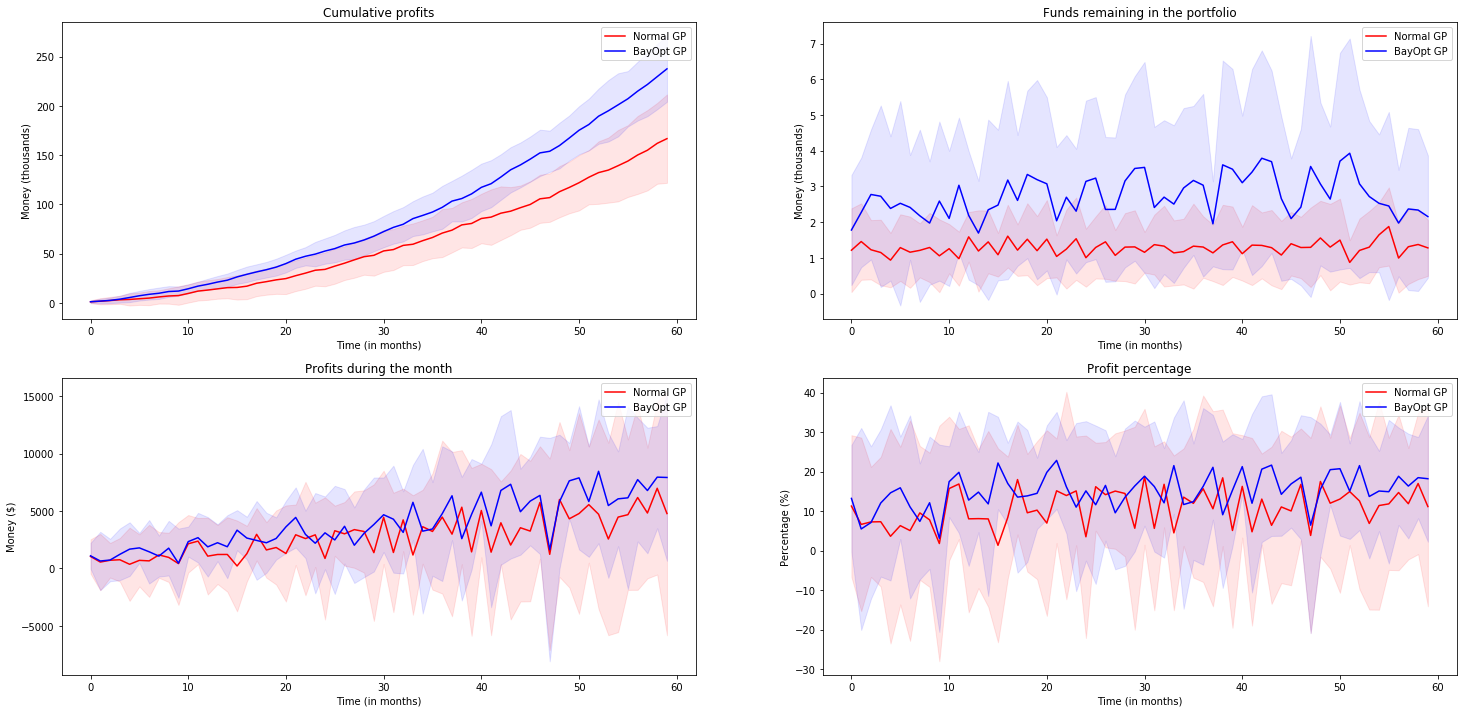

In [157]:
print("Mean Total Profits:")
print(np.mean(np.sum(perf_gp[:,:,0], axis=1)))
print(np.mean(np.sum(perf_bayes_opt[:,:,0], axis=1)))

import os

from visualisation import plot_portfolio_performance, plot_portfolio_performance_comparisons

# Saving performances to pickle file and Loading performances from it
filename = os.path.join("results", "bo_gp_k_{:02d}_{}_{}_seeds_{}_{}".format(KAPPA,
                                                                             NUM_TRAIN_ROWS_GP,
                                                                             NUM_TRAIN_ROWS_BO,
                                                                             GP_TRAIN_SEED,
                                                                             BO_TRAIN_SEED
                                                                            ))
meta_info = ["Normal GP", "BayOpt GP"]
performances = [perf_gp, perf_bayes_opt]
store_performance_results(performances, meta_info, filename)

meta_info, loaded_perf = load_performance_results(filename)
print(meta_info)
plot_portfolio_performance_comparisons(loaded_perf, legend_names=meta_info)